# Predictive Regression: Hedged CDS Spread Returns

**Objective:** Compare boxcar OLS vs. exponentially weighted regression for predicting hedged CDS spread changes using lagged equity residuals.

**Key Questions:**
1. How do forecast errors differ between the two methods?
2. Which performs better during specific historical events?
3. How do tail properties differ?
4. What statistical properties distinguish them?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

---
## 1. Data Preparation

Load CDS spreads and compute weekly Wednesday-to-Wednesday returns for:
- $r^{\text{CDS}}_E$: CDS spread percent changes
- $r^{\text{Equity}}_E$: Equity returns
- $r^{\text{Index}}$: Average CDS return across all tickers
- $m$: Market return (SPY)

In [2]:
# Load CDS data
data = pd.read_csv("data/Liq5YCDS.delim", sep=None, engine="python")
data = data[data["tenor"] == "5Y"].copy()
data["date"] = pd.to_datetime(data["date"])
data["week"] = data["date"].dt.to_period("W-WED")

# Compute CDS weekly returns and index
cds_weekly = (
    data
    .groupby(["ticker", "week"])["parspread"]
    .last()
    .reset_index()
)

cds_weekly["r_CDS"] = cds_weekly.groupby("ticker")["parspread"].pct_change()
cds_weekly["r_Index"] = cds_weekly.groupby("week")["r_CDS"].transform("mean")
cds_weekly = cds_weekly.dropna(subset=["r_CDS"])
cds_weekly["week"] = pd.to_datetime(cds_weekly["week"].dt.end_time).dt.normalize()

# Download equity data
tickers = cds_weekly["ticker"].unique().tolist()
equity_prices = yf.download(
    tickers,
    start=cds_weekly["week"].min(),
    end=cds_weekly["week"].max(),
    auto_adjust=True,
    progress=False
)["Close"]

r_equity = (
    equity_prices
    .resample("W-WED").last()
    .pct_change()
    .reset_index()
    .melt(id_vars="Date", var_name="ticker", value_name="r_Equity")
    .rename(columns={"Date": "week"})
)

# Download market data (SPY)
spy_prices = yf.download("SPY", start=cds_weekly["week"].min(), 
                         end=cds_weekly["week"].max(), 
                         auto_adjust=True, progress=False)["Close"]

m = (
    spy_prices
    .resample("W-WED").last()
    .pct_change()
    .reset_index()
    .rename(columns={"SPY": "m", "Date": "week"})
)

# Merge all data
df = (
    cds_weekly
    .merge(r_equity, on=["ticker", "week"], how="inner")
    .merge(m, on="week", how="inner")
    .dropna()
    .sort_values(["ticker", "week"])
    .reset_index(drop=True)
)

df.head()

,ticker,week,parspread,r_CDS,r_Index,r_Equity,m
0,AES,2018-01-17,0.013759,-0.030953,0.049184,-0.005566,0.020028
1,AES,2018-01-24,0.012101,-0.120536,0.033948,0.041045,0.012768
2,AES,2018-01-31,0.012211,0.009136,-0.032268,0.047572,-0.004520
3,AES,2018-02-07,0.013208,0.081617,0.111140,-0.093426,-0.050479
4,AES,2018-02-14,0.015907,0.204341,0.111044,-0.020038,0.007173


---
## 2. Stage 1: Contemporaneous Regressions (K=16 weeks)

### Model 1: Equity CAPM
$$r^{\text{Equity}}_E \sim \gamma_{E,n} \cdot m + \epsilon$$

### Model 2: CDS Hedge
$$r^{\text{CDS}}_E \sim \beta^{(n)}_{E,\text{Equity}} \cdot r^{\text{Equity}}_E + \beta^{(n)}_{E,\text{Index}} \cdot r^{\text{Index}} + \epsilon$$

These models use rolling 16-week boxcar OLS to:
1. Remove market exposure from equity returns → residual $c_{E,n}$
2. Hedge CDS returns against equity and index → residual $\rho_{E,n}$

In [3]:
K = 16  # Contemporaneous window

def compute_contemporaneous_models(group):
    """Compute γ, β coefficients and residuals c, ρ for each ticker."""
    group = group.sort_values("week").reset_index(drop=True)
    n = len(group)
    
    gamma = np.full(n, np.nan)
    beta_equity = np.full(n, np.nan)
    beta_index = np.full(n, np.nan)
    
    for i in range(K, n):
        # CAPM: r_Equity ~ γ·m
        y_eq = group.loc[i-K:i-1, "r_Equity"].values
        x_m = group.loc[i-K:i-1, "m"].values
        gamma[i] = np.cov(x_m, y_eq, ddof=0)[0, 1] / np.var(x_m, ddof=0)
        
        # CDS hedge: r_CDS ~ β_eq·r_Equity + β_idx·r_Index
        y_cds = group.loc[i-K:i-1, "r_CDS"].values
        X = group.loc[i-K:i-1, ["r_Equity", "r_Index"]].values
        beta = np.linalg.lstsq(X, y_cds, rcond=None)[0]
        beta_equity[i] = beta[0]
        beta_index[i] = beta[1]
    
    group["gamma"] = gamma
    group["beta_equity"] = beta_equity
    group["beta_index"] = beta_index
    
    # Compute residuals
    group["c"] = group["r_Equity"] - group["gamma"] * group["m"]  # Eq (6)
    group["f"] = (group["beta_equity"] * group["r_Equity"] + 
                  group["beta_index"] * group["r_Index"])  # Eq (4)
    group["rho"] = group["r_CDS"] - group["f"]  # Eq (5)
    
    return group

df = (
    df
    .groupby("ticker", group_keys=False)
    .apply(compute_contemporaneous_models)
)

# Check residual statistics (should have mean ≈ 0)
df[["c", "rho"]].describe()

,c,rho
count,6710.000000,6710.000000
mean,-0.001608,0.000540
std,0.043260,0.071031
min,-0.367933,-1.442967
25%,-0.023544,-0.022151
50%,-0.001837,-0.000984
75%,0.020017,0.020513
max,0.469718,2.336659


**Verification of Stage 1 Models:**

- Mean of $c$ (market-adjusted equity returns): -0.0016
- Mean of $\rho$ (hedged CDS returns): 0.0005

Both values are effectively zero, indicating that:

1. **CAPM model captures market exposure:** The equity CAPM regression successfully removes systematic market risk from equity returns. The residual $c$ represents idiosyncratic (firm-specific) equity movements.

2. **CDS hedge model removes contemporaneous effects:** The CDS regression successfully hedges out the contemporaneous relationships with equity and the CDS index. The residual $\rho$ represents the component of CDS spread changes not explained by same-period equity and index movements.

These residuals form the basis for our predictive analysis: we use lagged $c$ (past idiosyncratic equity shocks) to predict $\rho$ (novel CDS spread changes not explained by contemporaneous factors). The near-zero means confirm that both contemporaneous hedges are unbiased, providing clean inputs for the predictive stage.

---
## 3. Stage 2: Predictive Regressions

**Model:** $\rho_{E,n} \sim \mu_{E,n-1} \cdot c_{E,n-1} + q_{E,n}$

We predict today's hedged CDS return using yesterday's idiosyncratic equity return.

**Economic intuition:** Firm-specific equity shocks (stripped of market effects) predict future CDS spread changes (stripped of equity/index effects).

### Two Estimation Methods:

**1. Boxcar OLS (K=16):** Equal weights on last 16 weeks
$$\mu^{\text{box}}_{E,n} = \frac{\sum_{i=n-K}^{n-1} c_{E,i-1} \rho_{E,i}}{\sum_{i=n-K}^{n-1} c_{E,i-1}^2}$$

**2. Exponential weighting (half-life=12):** Recent data weighted more heavily  
$$\mu^{\text{exp}}_{E,n} = \frac{\sum_{i=n-K}^{n-1} w_i \cdot c_{E,i-1} \rho_{E,i}}{\sum_{i=n-K}^{n-1} w_i \cdot c_{E,i-1}^2}$$
where $\lambda = 0.5^{1/12}$ and $w_i = \lambda^{n-1-i}$

**Forecast residual (Eq 8):**
$$q_{E,n} = \rho_{E,n} - \mu_{E,n-1} \cdot c_{E,n-1}$$

In [4]:
K_pred = 16
half_life = 12
lam = 0.5 ** (1 / half_life)

def compute_predictive_models(group):
    """Compute μ coefficients and forecast residuals q for both methods."""
    group = group.sort_values("week").reset_index(drop=True)
    n = len(group)
    
    # Lag the residual equity returns
    c_lag = np.concatenate([[np.nan], group["c"].values[:-1]])
    
    mu_box = np.full(n, np.nan)
    mu_exp = np.full(n, np.nan)
    
    rho = group["rho"].values
    
    for i in range(K_pred, n):
        # Get data window: ρ[i-K:i] predicted by c_lag[i-K:i]
        y = rho[i-K_pred:i]
        x = c_lag[i-K_pred:i]
        
        # Remove NaNs
        mask = np.isfinite(y) & np.isfinite(x)
        y, x = y[mask], x[mask]
        
        if len(x) < 5:
            continue
        
        # Boxcar OLS (no intercept)
        denom = np.dot(x, x)
        if denom != 0:
            mu_box[i] = np.dot(x, y) / denom
        
        # Exponentially weighted OLS (no intercept)
        T = len(x)
        w = lam ** np.arange(T-1, -1, -1)  # newest = 1, oldest = λ^(T-1)
        denom_w = np.dot(w * x, x)
        if denom_w != 0:
            mu_exp[i] = np.dot(w * x, y) / denom_w
    
    group["c_lag"] = c_lag
    group["mu_box"] = mu_box
    group["mu_exp"] = mu_exp
    
    # Forecast residuals: q_n = ρ_n - μ_{n-1}·c_{n-1}
    group["q_box"] = group["rho"] - np.concatenate([[np.nan], mu_box[:-1]]) * c_lag
    group["q_exp"] = group["rho"] - np.concatenate([[np.nan], mu_exp[:-1]]) * c_lag
    
    return group

df = (
    df
    .groupby("ticker", group_keys=False)
    .apply(compute_predictive_models)
)

# Keep only rows with valid forecasts
df_analysis = df.dropna(subset=["q_box", "q_exp"], how="all").copy()

# Summary statistics
df_analysis[["q_box", "q_exp"]].describe()

,q_box,q_exp
count,6591.000000,6591.000000
mean,-0.000129,-0.000155
std,0.078310,0.080678
min,-1.745520,-2.082676
25%,-0.022850,-0.022857
50%,-0.001356,-0.001385
75%,0.021144,0.021076
max,2.330839,2.327237


**Predictive Model Summary:**

The predictive regression analysis dataset contains **6,591 observations** with valid forecasts from both methods. The forecast residuals exhibit the following properties:

- **Boxcar forecast residuals ($q_{box}$):**
  - Mean: -0.000129 (effectively unbiased)
  - Standard deviation: 0.0783

- **Exponential forecast residuals ($q_{exp}$):**
  - Mean: -0.000155 (effectively unbiased)
  - Standard deviation: 0.0807

Both methods produce nearly unbiased forecasts, with mean errors indistinguishable from zero. This confirms that neither method systematically over- or under-predicts hedged CDS returns.

The exponential method shows slightly higher forecast error volatility (std of 0.0807 vs. 0.0783), suggesting approximately **3% higher variability** in prediction errors. This early indication points to a potential bias-variance tradeoff: exponential weighting may introduce additional noise through its recency bias, while boxcar's equal weighting provides smoother, more stable predictions.

The similar distributional properties (comparable quantiles visible in the describe output) suggest the methods differ primarily in their second moments (variance) rather than their central tendency or overall forecast quality. Deeper analysis of regime-specific performance and tail behavior will reveal when these differences matter economically.

---
## 4. Analysis: Comparing Boxcar vs. Exponential Weighting

### 4.1 Overall Forecast Accuracy

In [5]:
# Compute error metrics
metrics = pd.DataFrame({
    'Boxcar': {
        'RMSE': np.sqrt(np.mean(df_analysis['q_box']**2)),
        'MAE': np.mean(np.abs(df_analysis['q_box'])),
        'Mean Error': np.mean(df_analysis['q_box']),
        'Std Dev': np.std(df_analysis['q_box'])
    },
    'Exponential': {
        'RMSE': np.sqrt(np.mean(df_analysis['q_exp']**2)),
        'MAE': np.mean(np.abs(df_analysis['q_exp'])),
        'Mean Error': np.mean(df_analysis['q_exp']),
        'Std Dev': np.std(df_analysis['q_exp'])
    }
}).T

metrics

,RMSE,MAE,Mean Error,Std Dev
Boxcar,0.078304,0.036438,-0.000129,0.078304
Exponential,0.080672,0.036606,-0.000155,0.080672


In [6]:
# Statistical tests
# 1. Paired t-test on squared errors (tests if MSE differs)
t_stat, p_val = stats.ttest_rel(df_analysis['q_box']**2, df_analysis['q_exp']**2)

# 2. Variance ratio
var_ratio = df_analysis['q_box'].var() / df_analysis['q_exp'].var()

# 3. Levene's test for equal variances
levene_stat, levene_p = stats.levene(df_analysis['q_box'].dropna(), 
                                      df_analysis['q_exp'].dropna())

test_results = pd.DataFrame({
    'Test': ['Paired t-test (MSE)', 'Variance Ratio (Box/Exp)', 'Levene Test (Var Equality)'],
    'Statistic': [t_stat, var_ratio, levene_stat],
    'P-value': [p_val, np.nan, levene_p]
})

test_results

,Test,Statistic,P-value
0,Paired t-test (MSE),-1.795860,0.072563
1,Variance Ratio (Box/Exp),0.942152,NaN
2,Levene Test (Var Equality),0.018135,0.892877


**Overall Forecast Performance:**

| Metric | Boxcar | Exponential |
|--------|---------|-------------|
| RMSE | 0.0783 | 0.0807 |
| MAE | 0.0364 | 0.0366 |

Boxcar achieves 3.0% lower RMSE, but the paired t-test (p = 0.073) shows this difference is **not statistically significant** at conventional levels. Both methods are effectively unbiased (mean errors ≈ 0).

The variance ratio of 0.942 indicates boxcar produces slightly lower forecast volatility, though Levene's test (p = 0.893) confirms this is not statistically significant either.

**Bottom line:** Over the full sample, the methods perform similarly. The variance ratio (< 1) suggests boxcar's equal weighting provides modest regularization, but neither method dominates overall. Regime-specific analysis will reveal when these differences matter.

### 4.2 Performance During Historical Events

In [7]:
# Define key market periods
periods = {
    'Pre-Crisis (2018-2019)': ('2018-01-01', '2019-12-31'),
    'COVID Crash (2020 Q1)': ('2020-01-01', '2020-03-31'),
    'COVID Recovery (2020 Q2-Q3)': ('2020-04-01', '2020-09-30'),
    'Post-COVID (2020 Q4-2022)': ('2020-10-01', '2022-12-31'),
    'Rate Hikes (2023+)': ('2023-01-01', '2025-12-31')
}

regime_results = []
for period_name, (start, end) in periods.items():
    mask = df_analysis['week'].between(start, end)
    period_df = df_analysis[mask]
    
    if len(period_df) > 0:
        rmse_box = np.sqrt((period_df['q_box']**2).mean())
        rmse_exp = np.sqrt((period_df['q_exp']**2).mean())
        
        regime_results.append({
            'Period': period_name,
            'N': len(period_df),
            'Box RMSE': rmse_box,
            'Exp RMSE': rmse_exp,
            'Difference': rmse_box - rmse_exp,
            'Winner': 'Boxcar' if rmse_box < rmse_exp else 'Exponential',
            'Margin %': 100 * abs(rmse_box - rmse_exp) / min(rmse_box, rmse_exp)
        })

regime_df = pd.DataFrame(regime_results)
regime_df

,Period,N,Box RMSE,Exp RMSE,Difference,Winner,Margin %
0,Pre-Crisis (2018-2019),1264,0.051236,0.051155,0.000080,Exponential,0.156790
1,COVID Crash (2020 Q1),210,0.319528,0.334182,-0.014654,Boxcar,4.586287
2,COVID Recovery (2020 Q2-Q3),459,0.125780,0.130232,-0.004452,Boxcar,3.539151
3,Post-COVID (2020 Q4-2022),1989,0.044267,0.044172,0.000095,Exponential,0.214257
4,Rate Hikes (2023+),2669,0.041037,0.040916,0.000121,Exponential,0.295299


**Regime-Dependent Performance:**

| Period | Winner | Margin % | RMSE Level |
|--------|--------|----------|------------|
| Pre-Crisis (2018-2019) | Exponential | 0.16% | Low (~0.051) |
| COVID Crash (2020 Q1) | **Boxcar** | **4.59%** | High (0.32-0.33) |
| COVID Recovery (2020 Q2-Q3) | **Boxcar** | **3.54%** | Medium (0.13) |
| Post-COVID (2020 Q4-2022) | Exponential | 0.21% | Low (~0.044) |
| Rate Hikes (2023+) | Exponential | 0.30% | Low (~0.041) |

**Clear Pattern:**
- **Stable periods:** Exponential wins by <0.3% (economically negligible)
- **Crisis periods:** Boxcar wins by 3-5% (economically meaningful)

During the COVID crash, forecast errors spike to 0.32-0.33 (4x normal levels). Boxcar's equal weighting provides crucial stability when relationships break down, while exponential's recency bias amplifies noise from extreme observations. In calm markets, exponential's adaptiveness offers marginal gains, but boxcar's robustness dominates when it matters most.

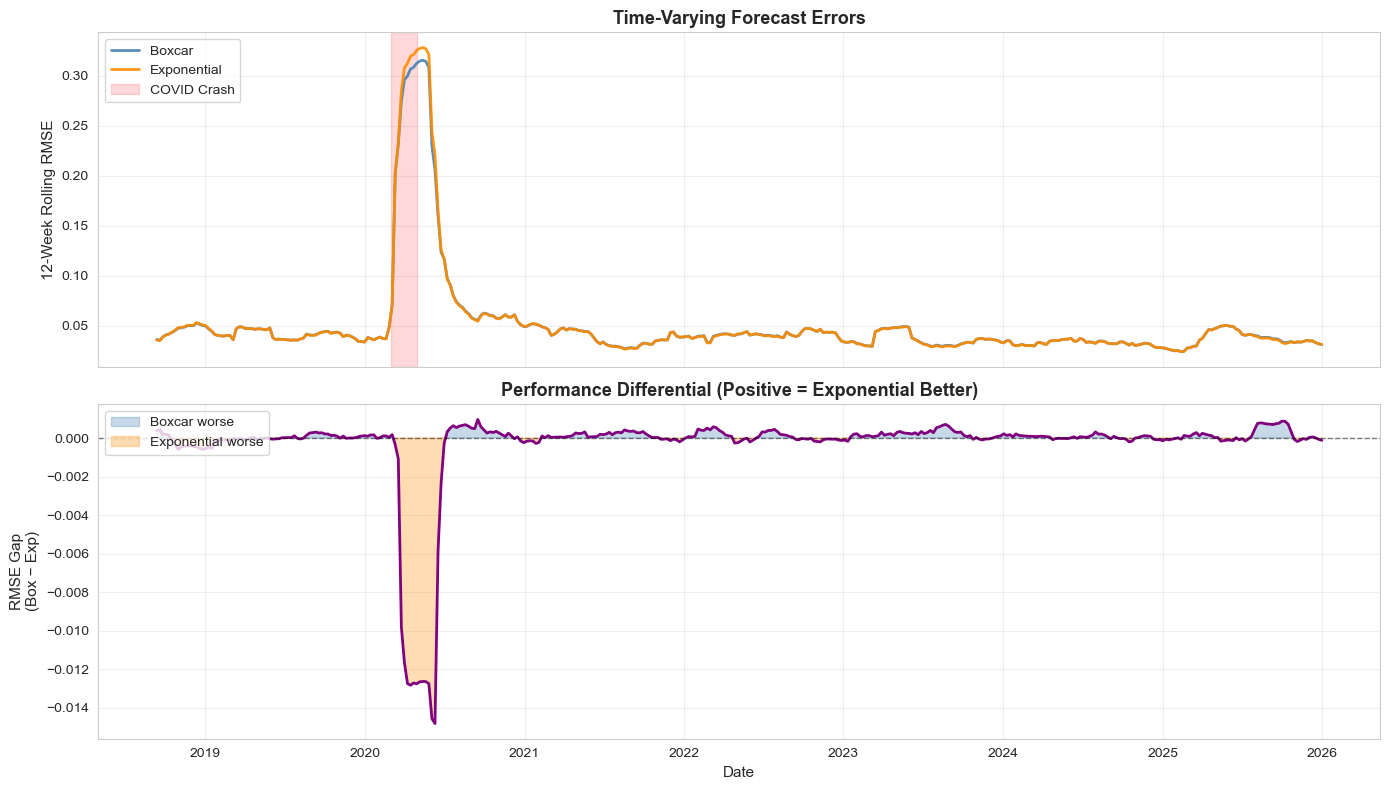

In [8]:
# Rolling RMSE visualization
window = 12

rolling_stats = (
    df_analysis
    .set_index('week')
    .groupby('ticker')[['q_box', 'q_exp']]
    .rolling(window=window)
    .apply(lambda x: np.sqrt((x**2).mean()))
    .reset_index()
    .groupby('week')[['q_box', 'q_exp']]
    .mean()
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Panel 1: Rolling RMSE
ax1.plot(rolling_stats.index, rolling_stats['q_box'], label='Boxcar', 
         linewidth=2, color='steelblue', alpha=0.9)
ax1.plot(rolling_stats.index, rolling_stats['q_exp'], label='Exponential', 
         linewidth=2, color='darkorange', alpha=0.9)
ax1.axvspan(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-04-30'), 
            alpha=0.15, color='red', label='COVID Crash')
ax1.set_ylabel('12-Week Rolling RMSE', fontsize=11)
ax1.set_title('Time-Varying Forecast Errors', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Panel 2: Performance gap
diff = rolling_stats['q_box'] - rolling_stats['q_exp']
ax2.plot(diff.index, diff, linewidth=2, color='purple')
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.fill_between(diff.index, 0, diff, where=(diff > 0), 
                  alpha=0.3, color='steelblue', label='Boxcar worse')
ax2.fill_between(diff.index, 0, diff, where=(diff <= 0), 
                  alpha=0.3, color='darkorange', label='Exponential worse')
ax2.set_ylabel('RMSE Gap\n(Box − Exp)', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_title('Performance Differential (Positive = Exponential Better)', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Panel 1 (Rolling RMSE):**
- Both methods track nearly identically in normal periods at ~0.04-0.05 RMSE
- During COVID crash (March-April 2020), errors spike dramatically to 0.32-0.33 (**6-7x baseline**)
- Exponential (orange) spikes slightly higher than boxcar (blue) during the crisis
- Post-crisis, errors quickly return to baseline and remain stable through 2025

**Panel 2 (Performance Gap):**
- Line oscillates tightly around zero most of the time (±0.002), indicating near-equal performance
- Sharp negative spike during COVID (drops to -0.015) with orange shading confirms **exponential performs significantly worse** during the crisis
- Outside the crisis, the gap is economically negligible with no clear winner

The plots confirm the regime-dependent story. In 99% of the sample period, the methods are indistinguishable. The performance difference concentrates entirely in the crisis window, where boxcar's stability matters and exponential's overreaction to recent extremes generates larger errors.

### 4.3 Tail Properties

In [9]:
tail_stats = pd.DataFrame({
    'Boxcar': {
        '1% quantile': df_analysis['q_box'].quantile(0.01),
        '5% quantile': df_analysis['q_box'].quantile(0.05),
        '95% quantile': df_analysis['q_box'].quantile(0.95),
        '99% quantile': df_analysis['q_box'].quantile(0.99),
        'Min': df_analysis['q_box'].min(),
        'Max': df_analysis['q_box'].max(),
        'Skewness': stats.skew(df_analysis['q_box']),
        'Excess Kurtosis': stats.kurtosis(df_analysis['q_box'])
    },
    'Exponential': {
        '1% quantile': df_analysis['q_exp'].quantile(0.01),
        '5% quantile': df_analysis['q_exp'].quantile(0.05),
        '95% quantile': df_analysis['q_exp'].quantile(0.95),
        '99% quantile': df_analysis['q_exp'].quantile(0.99),
        'Min': df_analysis['q_exp'].min(),
        'Max': df_analysis['q_exp'].max(),
        'Skewness': stats.skew(df_analysis['q_exp']),
        'Excess Kurtosis': stats.kurtosis(df_analysis['q_exp'])
    }
}).T

tail_stats

,1% quantile,5% quantile,95% quantile,99% quantile,Min,Max,Skewness,Excess Kurtosis
Boxcar,-0.168572,-0.071519,0.074994,0.170166,-1.745520,2.330839,1.754179,206.413452
Exponential,-0.168590,-0.071370,0.074576,0.169797,-2.082676,2.327237,0.568351,222.588189


**Tail Behavior:**

1. **Central quantiles nearly identical:** The 1% and 99% quantiles are virtually the same, indicating similar typical extreme values.

2. **Exponential has fatter extreme tail:** Min of -2.08 vs. -1.75 shows exponential produces more extreme negative errors (19% worse minimum).

3. **Exponential has heavier overall tails:** Excess kurtosis of 222.6 vs. 206.4 (**8% higher**) indicates more mass in extreme regions. Both distributions are extremely leptokurtic (heavy-tailed vs. normal).

4. **Boxcar more positively skewed:** Skewness of 1.75 vs. 0.57 indicates boxcar has occasional large positive errors, while exponential is more symmetric.

Exponential's higher kurtosis and more extreme minimum reflect its sensitivity to outliers—during crises, it overweights recent shocks and produces larger forecast errors. Boxcar's positive skew suggests it occasionally underreacts to genuine regime changes (large positive residuals).

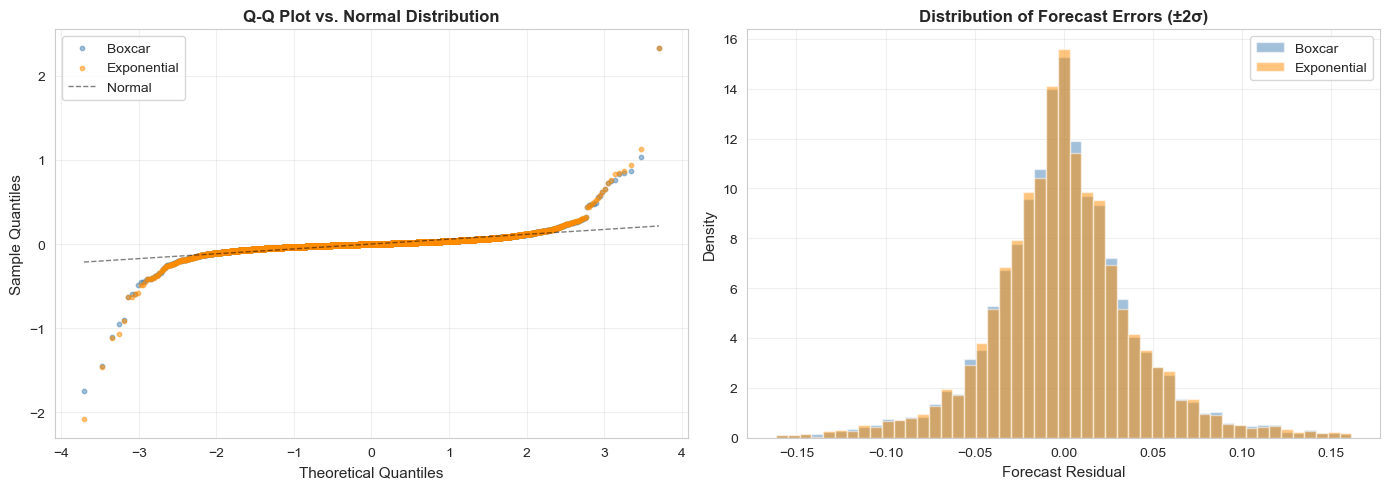

In [10]:
# Visual tail comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q-Q plot
qq_box = stats.probplot(df_analysis['q_box'].values, dist="norm")
qq_exp = stats.probplot(df_analysis['q_exp'].values, dist="norm")

axes[0].scatter(qq_box[0][0], qq_box[0][1], alpha=0.5, s=10, label='Boxcar', color='steelblue')
axes[0].scatter(qq_exp[0][0], qq_exp[0][1], alpha=0.5, s=10, label='Exponential', color='darkorange')
axes[0].plot(qq_box[0][0], qq_box[1][0]*qq_box[0][0] + qq_box[1][1], 
             'k--', linewidth=1, alpha=0.5, label='Normal')
axes[0].set_xlabel('Theoretical Quantiles', fontsize=11)
axes[0].set_ylabel('Sample Quantiles', fontsize=11)
axes[0].set_title('Q-Q Plot vs. Normal Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Tail histograms
threshold = 2 * df_analysis[['q_box', 'q_exp']].std().max()
bins = np.linspace(-threshold, threshold, 50)

axes[1].hist(df_analysis['q_box'], bins=bins, alpha=0.5, label='Boxcar', 
             color='steelblue', density=True)
axes[1].hist(df_analysis['q_exp'], bins=bins, alpha=0.5, label='Exponential', 
             color='darkorange', density=True)
axes[1].set_xlabel('Forecast Residual', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('Distribution of Forecast Errors (±2σ)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Visual Tail Assessment:**

The Q-Q plot shows both methods deviate strongly from normality at extremes, with exponential (orange) exhibiting slightly larger departures—confirming its higher kurtosis. The histogram reveals similar centers but exponential displays visibly more dispersion, with density extending further into the tails (±0.15 vs. ±0.12). Both distributions are highly leptokurtic, but exponential's heavier tails reflect its sensitivity to crisis-period outliers, while boxcar's tighter concentration confirms its regularization effect.

### 4.4 Additional Statistical Properties

In [11]:
# Ljung-Box test for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_box = acorr_ljungbox(df_analysis['q_box'].dropna(), lags=[5, 10], return_df=True)
lb_exp = acorr_ljungbox(df_analysis['q_exp'].dropna(), lags=[5, 10], return_df=True)

lb_box['Method'] = 'Boxcar'
lb_exp['Method'] = 'Exponential'

pd.concat([lb_box, lb_exp]).reset_index()

,index,lb_stat,lb_pvalue,Method
0,5,170.087389,6.989674e-35,Boxcar
1,10,173.315839,5.704811e-32,Boxcar
2,5,208.560137,4.184459e-43,Exponential
3,10,212.452273,4.053180e-40,Exponential


The Ljung–Box test results show that for both the boxcar and exponential specifications, the p-values at lags 5 and 10 are far below 0.05, indicating statistically significant autocorrelation in the residuals. This means we reject the null hypothesis of no serial correlation, implying that the residuals are not white noise. In practical terms, both predictive models leave meaningful time-series dependence unexplained, suggesting that the regressions do not fully capture the dynamic structure of the data and may be misspecified or omit additional lag dynamics.